In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils as utils
from torchvision import transforms as T
import albumentations as A
from albumentations.pytorch import ToTensor
import torchvision
from tqdm import tqdm
import random
import numpy as np
from collections import OrderedDict
import PIL
from PIL import Image, ImageDraw, ImageFont
import cv2


from sklearn.metrics import roc_auc_score

from matplotlib import pyplot as plt
import time
import os

In [52]:
from pathlib import Path
root = Path("data")

## Helpers

In [53]:
def show_batch(x,y,shape = None):
    """
    input: 
        x(Tensor[num_images, rows, columns]): images tensor
        y(array): labels
        shape(tuple): (rows,col) 
    output:
        grid of smaple images
    """

    if not shape:
        shape = (int(x.shape[0]**0.5), int(x.shape[0]**0.5))

    fig, axs = plt.subplots(nrows= shape[0], ncols=shape[1], figsize = (12,8))
    index = 0
    for row in axs:
        for ax in row:
            ax.imshow(x[index])
            ax.set_xlabel(y[index], )
            index+=1

    # plt.subplots_adjust(wspace = 0.2, hspace = 0.5) 
    fig.tight_layout()
    plt.show()
    
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Hyper-parameters

In [54]:
BATCH_SIZE = 16
NUM_EPOCHS = 5
LEARNING_RATE = 0.0001
RANDOM_SEED = 42

DEVICE = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

## Dataset

In [55]:
#  for direc in root.glob("*"):
#     if direc.is_dir():
#         source = direc / "0"
#         target = direc / "1"
    
#     for s_char in source.glob("*.png"):
#         print(Image.open(s_char).size)

In [58]:
## checks the errors

from pathlib import Path
root = Path("data")
for direc in root.glob("*"):
    if direc.is_dir():
        source = direc / "0"
        target = direc / "1"

        
        target_set = set()
        for t_char in target.glob("*.png"):
            target_set.add(t_char.name[0])
        
        for s_char in source.glob("*.png"):
            if s_char.name[0] not in target_set:
                print(direc.name)
                print(s_char.name[0])

In [78]:
class TycOCRDataset(Dataset):    # 集成Dataset类以定制
      
    def __init__(self, root, train = True, src_transforms = None, tar_transforms = None):
            
        self.src_transforms = src_transforms
        self.tar_transforms = tar_transforms

        self.samples = []
        self.labels = []

        for direc in root.glob("*"):
            if direc.is_dir():
                source = direc / "0"
                target = direc / "1"

                target_set = set()

                for s_char in source.glob("*.png"):
                    for t_char in target.glob("*.png"):
                        self.samples.append( (s_char, t_char))
                        if t_char.name[0] == s_char.name[0]:
                            self.labels.append(1)
                        else:
                            self.labels.append(0)

    def __getitem__(self, index):

        img0,img1 = self.samples[index]
        
        # Read an image with OpenCV
        img0 = cv2.imread(str(img0))
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
        
        
        img1 = cv2.imread(str(img1))
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    
    
        if self.src_transforms:  
            img0 = self.src_transforms(image = img0)["image"]
        
        if self.tar_transforms:
            img1 = self.tar_transforms(image = img1)["image"]

        return img0, img1 , torch.tensor([self.labels[index]],dtype=torch.float32)    
    
    def __len__(self):       # 数据总长
        return len(self.samples)

In [79]:
root

PosixPath('data')

In [123]:
src_transforms = A.Compose([
                        A.Resize(36,36),
                        A.Rotate(30,interpolation = cv2.INTER_NEAREST),
                        A.CenterCrop(32,32),
                        A.RandomBrightnessContrast(p=0.5),
                        A.ToGray(p = 1),
                        A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
                        ToTensor()
                    ])

tar_transforms = A.Compose([
                        A.Resize(36,36),
                        A.Rotate(30,interpolation = cv2.INTER_NEAREST),
                        A.CenterCrop(32,32),
                        A.RandomGamma(),
                        A.RandomBrightnessContrast(p=0.5),
                        A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
                        ToTensor()
                    ])


test_data_transform = A.Compose([
    A.Resize(32,32),
    A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ToTensor()
])


dataset = TycOCRDataset(root, train = True, src_transforms = src_transforms, tar_transforms = tar_transforms )


train_length = int(len(dataset) * 0.8)
val_length = len(dataset) - train_length

train_dataset, val_dataset = utils.data.random_split(dataset,[train_length, val_length])

train_dataloader = DataLoader(dataset = train_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=4,
                             shuffle=True)

val_dataloader = DataLoader(dataset = val_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=4,
                             shuffle=False)

dataset_loader = {"train": train_dataloader, "val": val_dataloader}

In [130]:
img0, img1, target = next(iter(train_dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

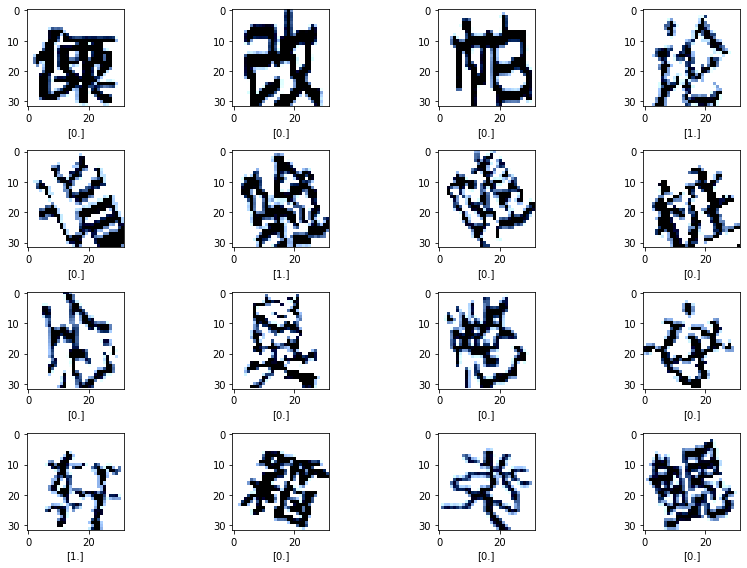

In [131]:
show_batch(img0.permute([0,2,3,1]), target.numpy(), (4,4))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

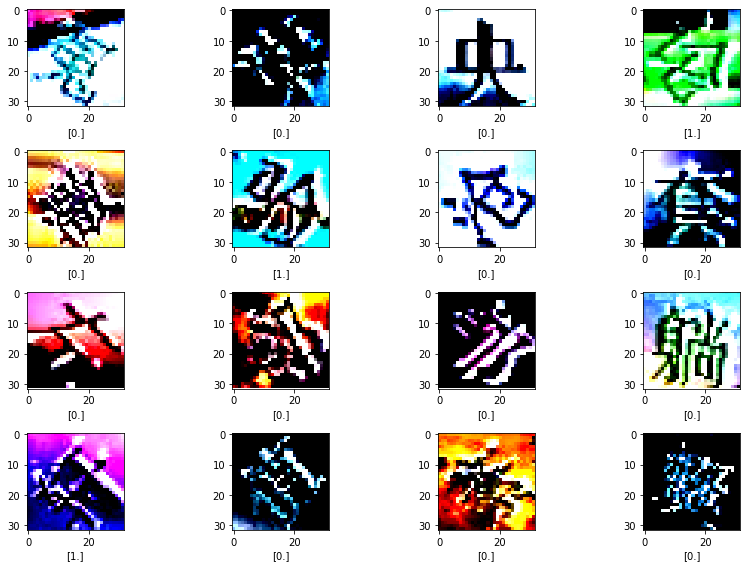

In [132]:
show_batch(img1.permute([0,2,3,1]), target.numpy(), (4,4))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


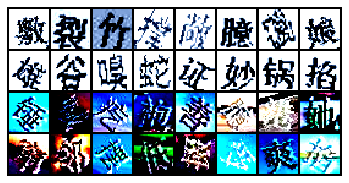

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


In [133]:
example_batch = next(iter(train_dataloader))
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Loss

## Model

In [134]:
base_model = torchvision.models.resnet18(pretrained=True)
for index, (name, layer) in enumerate(base_model.named_children()):
    print(index, name, " -> ", layer)
    print("--"* 40)

0 conv1  ->  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
--------------------------------------------------------------------------------
1 bn1  ->  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
--------------------------------------------------------------------------------
2 relu  ->  ReLU(inplace=True)
--------------------------------------------------------------------------------
3 maxpool  ->  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
--------------------------------------------------------------------------------
4 layer1  ->  Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64

In [135]:
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_dim = 128):
        super(SiameseNetwork, self).__init__()

        self.base_model_src = torchvision.models.resnet18(pretrained=True)
        self.base_model_src.fc = torch.nn.Linear(in_features=512, out_features = embedding_dim, bias = True)
        
        self.base_model_tar = torchvision.models.resnet18(pretrained=True)
        self.base_model_tar.fc = torch.nn.Linear(in_features=512, out_features = embedding_dim, bias = True)
        
        self.linear = nn.Sequential(
                torch.nn.Linear(in_features=embedding_dim, out_features = 32, bias = True),
                torch.nn.Dropout(p = 0.3),
                torch.nn.Linear(in_features=32, out_features=1)
        )
        
                
        
    def forward(self, input1, input2):
        output1 = self.base_model_src(input1)
        output2 = self.base_model_tar(input2)
        
        diff = output1 - output2
        
        logits = self.linear(diff)
        probas = torch.sigmoid(logits)
    
        return logits,probas

In [136]:
model = SiameseNetwork()
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience=2,
        threshold=0.01,
        factor = 0.2,
        verbose=True,
        mode='min')

In [137]:
def compute_auc(model, data_loader, device):
    model.eval()
    
    y_pred = []
    y_true = []
    
    for i, (img0,img1,label) in enumerate(data_loader):    
        img0 = img0.to(device)
        img1 = img1.to(device)
        label = label.to(device)
        logits, probas = model(img0,img1)        
        y_pred += list(torch.squeeze(probas,dim = 1 ).numpy())
        y_true += list(torch.squeeze(label, dim = 1).numpy())
            
    return roc_auc_score(y_true,y_pred)




def train_model(model, data_loader, optimizer, num_epochs,batch_size, device,metric_func, random_seed = 7):
    # Manual seed for deterministic data loader
    torch.manual_seed(random_seed)
    
    loss_list = []
    train_acc_list, valid_acc_list = [], []
    best_valid_acc = 0
    
    Criteria  = torch.nn.BCEWithLogitsLoss()
    
    for epoch in range(num_epochs):
        start = time.time()
        # set training mode
        model.train() 
        for batch_idx, (img0,img1,label) in enumerate(data_loader["train"]):
            img0 = img0.to(device)
            img1 = img1.to(device)
            label = label.to(device)

            ## forward pass
            logits, probas = model(img0,img1)
            
            loss = Criteria(logits,label)

            # backward pass
            # clear the gradients of all tensors being optimized
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ### Login
            loss_list.append(loss.item())
        
            print ('Epoch: {0:03d}/{1:03d} | Batch {2:03d}/{3:03d} | Loss: {4:.3f}'.format(
                epoch+1, num_epochs, batch_idx, 
                     len(train_dataset)//batch_size, loss))
        
        end = time.time()
        with torch.set_grad_enabled(False):
            train_acc = metric_func(model, data_loader["train"], device)
            valid_acc = metric_func(model, data_loader["val"], device)
            
            print('Epoch: {0:03d}/{1:03d} train auc: {2:.3f} | val auc: {3:.3f} | time: {4:.3f} s'.format(
                  epoch+1, num_epochs, train_acc, valid_acc, end-start))
            
            if not os.path.exists("tycocr_model_checkpoint"):
                os.mkdir("tycocr_model_checkpoint")
            
            if best_valid_acc <= valid_acc:
                best_valid_acc = valid_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'valid_roc': valid_acc,
                    'optimizer_state_dict': optimizer.state_dict(),
                }, "tycocr_model_checkpoint/best_model.pt")
            
            
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)
        
        scheduler.step(valid_acc)
            
    checkpoint = torch.load("tycocr_model_checkpoint/best_model.pt")
    model.load_state_dict(checkpoint["model_state_dict"])
            
    return model, loss_list, train_acc_list, valid_acc_list

In [138]:
# with torch.set_grad_enabled(False):
#     print(compute_auc(model, dataset_loader["val"], DEVICE))

In [140]:
model, loss_list, train_acc_list, valid_acc_list = train_model(model, 
            dataset_loader, 
            optimizer, 
            NUM_EPOCHS, 
            device = DEVICE, 
            batch_size = BATCH_SIZE,
            metric_func = compute_auc)

## Inference 

In [22]:
test_src_transforms = T.Compose([
                        T.Resize(36),
                        T.CenterCrop(34),
                        T.Resize(224),
                        T.RandomGrayscale(p = 1),
                        T.ToTensor(),
                        T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),      
                    ])

test_tar_transforms = T.Compose([
                        T.Resize(36),
                        T.Resize(30),
                        T.Resize(224),
                        T.RandomGrayscale(p = 1),
                        T.ToTensor(),
                        T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),      
                    ])


class TycOCRTestDataset(Dataset):
      
    def __init__(self, root, train = True, src_transforms = None, tar_transforms = None):
            
        self.src_transforms = src_transforms
        self.tar_transforms = tar_transforms

        self.samples = []
        self.labels = []

        for direc in root.glob("*"):
            if direc.is_dir():
                source = direc / "0"
                target = direc / "1"

                target_set = set()

                for s_char in source.glob("*.png"):
                    for t_char in target.glob("*.png"):
                        self.samples.append( (s_char, t_char))
                        if t_char.name[0] == s_char.name[0]:
                            self.labels.append(1)
                        else:
                            self.labels.append(0)

    def __getitem__(self, index):

        img0,img1 = self.samples[index]
        
        img0_name = img0.name.split(".")[0]
        img1_name = img1.name.split(".")[0]
        
        img0 = Image.open(img0) 
        img1 = Image.open(img1)


        if self.src_transforms:  
            img0 = self.src_transforms(img0)
        
        if self.tar_transforms:
            img1 = self.tar_transforms(img1)
            
        
        return img0,img1,torch.tensor(self.labels[index]), img0_name, img1_name   
    
    def __len__(self):       # 数据总长
        return len(self.samples)
    
test_dataset = TycOCRTestDataset(root, train = True, src_transforms = test_src_transforms, tar_transforms = test_tar_transforms )

In [23]:
with torch.set_grad_enabled(False):
    model.eval()
    for batch_idx, (img0,img1,label,img0_name, img1_name) in enumerate(test_dataset):
        img0 = torch.unsqueeze(img0.to(DEVICE),0)
        img1 = torch.unsqueeze(img1.to(DEVICE),0)
        label = label.to(DEVICE)
        
        output1, output2 = model(img0,img1)
        euclidean_distance = F.pairwise_distance(output1, output2)
        print('{} vs {} | Dissimilarity: {:.4f}'.format(img0_name,img1_name, euclidean_distance.item()))
        if batch_idx > 100:
            break

蠢_1 vs 蠢_2 | Dissimilarity: 0.6032
蠢_1 vs 腋_4 | Dissimilarity: 0.5827
蠢_1 vs 刘_1 | Dissimilarity: 0.6098
蠢_1 vs 嫌_3 | Dissimilarity: 0.6575
腋_2 vs 蠢_2 | Dissimilarity: 0.5939
腋_2 vs 腋_4 | Dissimilarity: 0.5654
腋_2 vs 刘_1 | Dissimilarity: 0.5933
腋_2 vs 嫌_3 | Dissimilarity: 0.6476
刘_3 vs 蠢_2 | Dissimilarity: 0.5753
刘_3 vs 腋_4 | Dissimilarity: 0.5607
刘_3 vs 刘_1 | Dissimilarity: 0.5884
刘_3 vs 嫌_3 | Dissimilarity: 0.6229
醉_2 vs 醉_1 | Dissimilarity: 0.6673
醉_2 vs 梆_3 | Dissimilarity: 0.8119
醉_2 vs 搓_5 | Dissimilarity: 0.6182
醉_2 vs 邓_4 | Dissimilarity: 0.7058
醉_2 vs 茅_2 | Dissimilarity: 0.7626
梆_1 vs 醉_1 | Dissimilarity: 0.6485
梆_1 vs 梆_3 | Dissimilarity: 0.8057
梆_1 vs 搓_5 | Dissimilarity: 0.5976
梆_1 vs 邓_4 | Dissimilarity: 0.6688
梆_1 vs 茅_2 | Dissimilarity: 0.7349
邓_3 vs 醉_1 | Dissimilarity: 0.6678
邓_3 vs 梆_3 | Dissimilarity: 0.8135
邓_3 vs 搓_5 | Dissimilarity: 0.6157
邓_3 vs 邓_4 | Dissimilarity: 0.6858
邓_3 vs 茅_2 | Dissimilarity: 0.7484
捍_1 vs 捍_1 | Dissimilarity: 0.5873
捍_1 vs 画_2 | Dissimi